### Load relevant packages and data

In [104]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import re
import calendar
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

hour_name = ["12am"]+[str(i)+"am" for i in range(1,12)]+["12pm"]+[str(i)+"pm" for i in range(1,12)]
day_name = list(calendar.day_name)
month_name = list(calendar.month_name)

calendar_label_dict = {"hour" : hour_name, "dayOfWeek": day_name, "month": month_name}



def to_camel(col_name):
    split_col_name = re.split( "_| ", col_name)
    
    if len(split_col_name)>1:
        
        col_name = "".join([x.capitalize() for x in split_col_name])
  
    col_name = col_name[0].lower()+col_name[1:]
    
    return col_name

def standardise(x):
    return (x-np.mean(x))/np.std(x)

def rolling_average(days, x, df, column_to_aggregate):
    return df[(df["date"]<=x) & (df["date"]>=(x- timedelta(days=days)))][column_to_aggregate].mean()

def rolling_sum(days, x, df, column_to_aggregate):
    return df[(df["date"]<=x) & (df["date"]>=(x- timedelta(days=days)))][column_to_aggregate].sum()


def window(df, grouper, agg_field, aggregation, new_col_name):
    # This function performs a similar function to pysparks window function. We want to partition the data by
    # grouper, and perform an aggregation over agg_field
        
    # Partition the data by the grouper
    gdf = df.groupby(grouper).agg({agg_field:[aggregation]}).reset_index()

    gdf.columns =  [grouper] + [new_col_name]


    # Merge back to original dataframe
    df = pd.merge(df, gdf, on=grouper, how="left")

    return df


os.chdir("C:/Users/timur/WB Datasets/")


trx_data = pd.read_csv("exercise_2_train_transaction.csv")


### Standardise column names to camel case, and see how many unique values each column has (this may point to columns which identify the unique card)

In [105]:
trx_data.columns = trx_data.columns.to_series().apply(lambda x: to_camel(x))

# Removing a subset of columns, they won't be used due to time contraints. Seperating the other cols so can analyse them individually

base_cols = ["transactionID", "isFraud","transactionDT","transactionAmt","productCD","card1","card2","card3","card4","card5","card6","addr1","addr2","dist1","dist2","pEmaildomain","rEmaildomain"]
ccols = ["c"+str(i) for i in range(1,15)]
mcols = ["m"+str(i) for i in range(1,10)]
dcols = ["d"+str(i) for i in range(1,16)]

cols_to_keep = base_cols + ccols + mcols + dcols

trx_data = trx_data[cols_to_keep].drop_duplicates()

trx_data.nunique()

transactionID     590540
isFraud                2
transactionDT     573349
transactionAmt     20902
productCD              5
card1              13553
card2                500
card3                114
card4                  4
card5                119
card6                  4
addr1                332
addr2                 74
dist1               2651
dist2               1751
pEmaildomain          59
rEmaildomain          60
c1                  1657
c2                  1216
c3                    27
c4                  1260
c5                   319
c6                  1328
c7                  1103
c8                  1253
c9                   205
c10                 1231
c11                 1476
c12                 1199
c13                 1597
c14                 1108
m1                     2
m2                     2
m3                     2
m4                     3
m5                     2
m6                     2
m7                     2
m8                     2
m9                     2


### View data and create a date columns

In [77]:
trx_data.sample(n=20)

,transactionID,isFraud,transactionDT,transactionAmt,productCD,card1,card2,card3,card4,card5,...,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15
291996,3278996,0,7192648,42.657,C,15885,545.0,185.0,visa,138.0,...,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0
276952,3263952,0,6731276,431.660,W,15497,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,94.0,0.0,NaN,NaN,NaN,94.0
364135,3351135,0,9047287,117.000,W,6530,206.0,150.0,mastercard,126.0,...,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN,NaN,0.0
582323,3569323,0,15549455,35.950,W,10023,111.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,17.0,17.0,NaN,NaN,NaN,17.0
322125,3309125,0,8008248,10.271,C,9026,545.0,185.0,visa,137.0,...,406.0,7.0,198.666672,0.666666,0.0,NaN,406.0,7.0,0.0,406.0
395519,3382519,0,9936300,27.000,S,9559,310.0,150.0,mastercard,224.0,...,801.0,0.0,578.000000,0.000000,801.0,NaN,NaN,578.0,417.0,801.0
311514,3298514,1,7757743,15.000,W,10057,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,48.0,45.0,NaN,NaN,NaN,48.0
223065,3210065,0,5259071,29.000,W,7585,553.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,66.0,NaN,NaN,NaN,NaN,421.0
179686,3166686,0,3952217,59.000,W,4518,216.0,150.0,mastercard,NaN,...,NaN,NaN,NaN,NaN,19.0,19.0,NaN,NaN,NaN,19.0
420692,3407692,0,10640443,107.950,W,7585,553.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,594.0,318.0,NaN,NaN,NaN,293.0


In [84]:
#The dd cols are timedelta, such as days between previous transaction, etc. 
trx_data[dcols].describe()

,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15
count,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000
mean,94.347568,169.563231,28.343348,140.002441,42.335965,69.805717,41.638950,146.058108,0.561057,123.982137,146.621465,54.037533,17.901295,57.724444,163.744579
std,157.660387,177.315865,62.384721,191.096774,89.000144,143.669253,99.743264,231.663840,0.316880,182.615225,186.042622,124.274558,67.614425,136.312450,202.726660
min,0.000000,0.000000,0.000000,-122.000000,0.000000,-83.000000,0.000000,0.000000,0.000000,0.000000,-53.000000,-83.000000,0.000000,-193.000000,-83.000000
25%,0.000000,26.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.958333,0.208333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,97.000000,8.000000,26.000000,10.000000,0.000000,0.000000,37.875000,0.666666,15.000000,43.000000,0.000000,0.000000,0.000000,52.000000
75%,122.000000,276.000000,27.000000,253.000000,32.000000,40.000000,17.000000,187.958328,0.833333,197.000000,274.000000,13.000000,0.000000,2.000000,314.000000
max,640.000000,640.000000,819.000000,869.000000,819.000000,873.000000,843.000000,1707.791626,0.958333,876.000000,670.000000,648.000000,847.000000,878.000000,879.000000


In [88]:
# The cc cols are counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked. 
trx_data[ccols].describe()

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14
count,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144574,4.480240,5.240343,10.241521,4.076227,32.539918,8.295215
std,133.569018,154.668899,0.150536,68.848459,25.786976,71.508467,61.727304,95.378574,16.674897,95.581443,94.336292,86.666218,129.364844,49.544262
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,1.000000
75%,3.000000,3.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,12.000000,2.000000
max,4685.000000,5691.000000,26.000000,2253.000000,349.000000,2253.000000,2255.000000,3331.000000,210.000000,3257.000000,3188.000000,3188.000000,2918.000000,1429.000000


In [89]:
# the dd cols are binary variables indicating whethere there is a match on names on card and address, etc. Still not sure exactly what this means
trx_data[mcols].describe()

,m1,m2,m3,m4,m5,m6,m7,m8,m9
count,319440,319440,319440,309096,240058,421180,244275,244288,244288
unique,2,2,2,3,2,2,2,2,2
top,T,T,T,M0,F,F,F,F,T
freq,319415,285468,251731,196405,132491,227856,211374,155251,205656


In [133]:
trx_data[trx_data['card1']==15775][["addr1", "d1"]].nunique()

addr1    16
d1       63
dtype: int64

In [4]:
# transactionDT is the time delta in seconds. Dividing by (60*60*24) will give us the number of days.  Get the max delta day
trx_data["transactionDT"].max()/(60*60*24)

182.99920138888888

In [106]:
# According to the discussions in the competition the origin for the transaction date is 2017-12-01
trx_data["transactionDate"]  =  pd.to_datetime(trx_data["transactionDT"],unit='s', origin=pd.Timestamp('2017-12-01 00:00:00'))
trx_data['date'] = trx_data["transactionDate"].dt.date
trx_data['date'] =  pd.to_datetime(trx_data['date'])

trx_data['dayOfWeek'] = trx_data["transactionDate"].dt.dayofweek
trx_data['hour'] = trx_data["transactionDate"].dt.hour
trx_data['month'] = trx_data["transactionDate"].dt.month
trx_data['dayOfMonth'] = trx_data["transactionDate"].dt.day

trx_data["logTransactionAmt"] = np.log(trx_data["transactionAmt"])

trx_data

,transactionID,isFraud,transactionDT,transactionAmt,productCD,card1,card2,card3,card4,card5,...,d13,d14,d15,transactionDate,date,dayOfWeek,hour,month,dayOfMonth,logTransactionAmt
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,0.0,2017-12-02 00:00:00,2017-12-02,5,0,12,2,4.226834
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,0.0,2017-12-02 00:00:01,2017-12-02,5,0,12,2,3.367296
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,315.0,2017-12-02 00:01:09,2017-12-02,5,0,12,2,4.077537
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,111.0,2017-12-02 00:01:39,2017-12-02,5,0,12,2,3.912023
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,2017-12-02 00:01:46,2017-12-02,5,0,12,2,3.912023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,56.0,2018-06-01 23:57:27,2018-06-01,4,23,6,1,3.891820
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,0.0,2018-06-01 23:57:29,2018-06-01,4,23,6,1,3.676301
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,0.0,2018-06-01 23:57:59,2018-06-01,4,23,6,1,3.432373
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,22.0,2018-06-01 23:58:08,2018-06-01,4,23,6,1,4.762174


### Analyze temporal patterns in transactions
Note these patterns are dependent on the origin we set above. I am going discuss the results on the assumption that the origin is correct

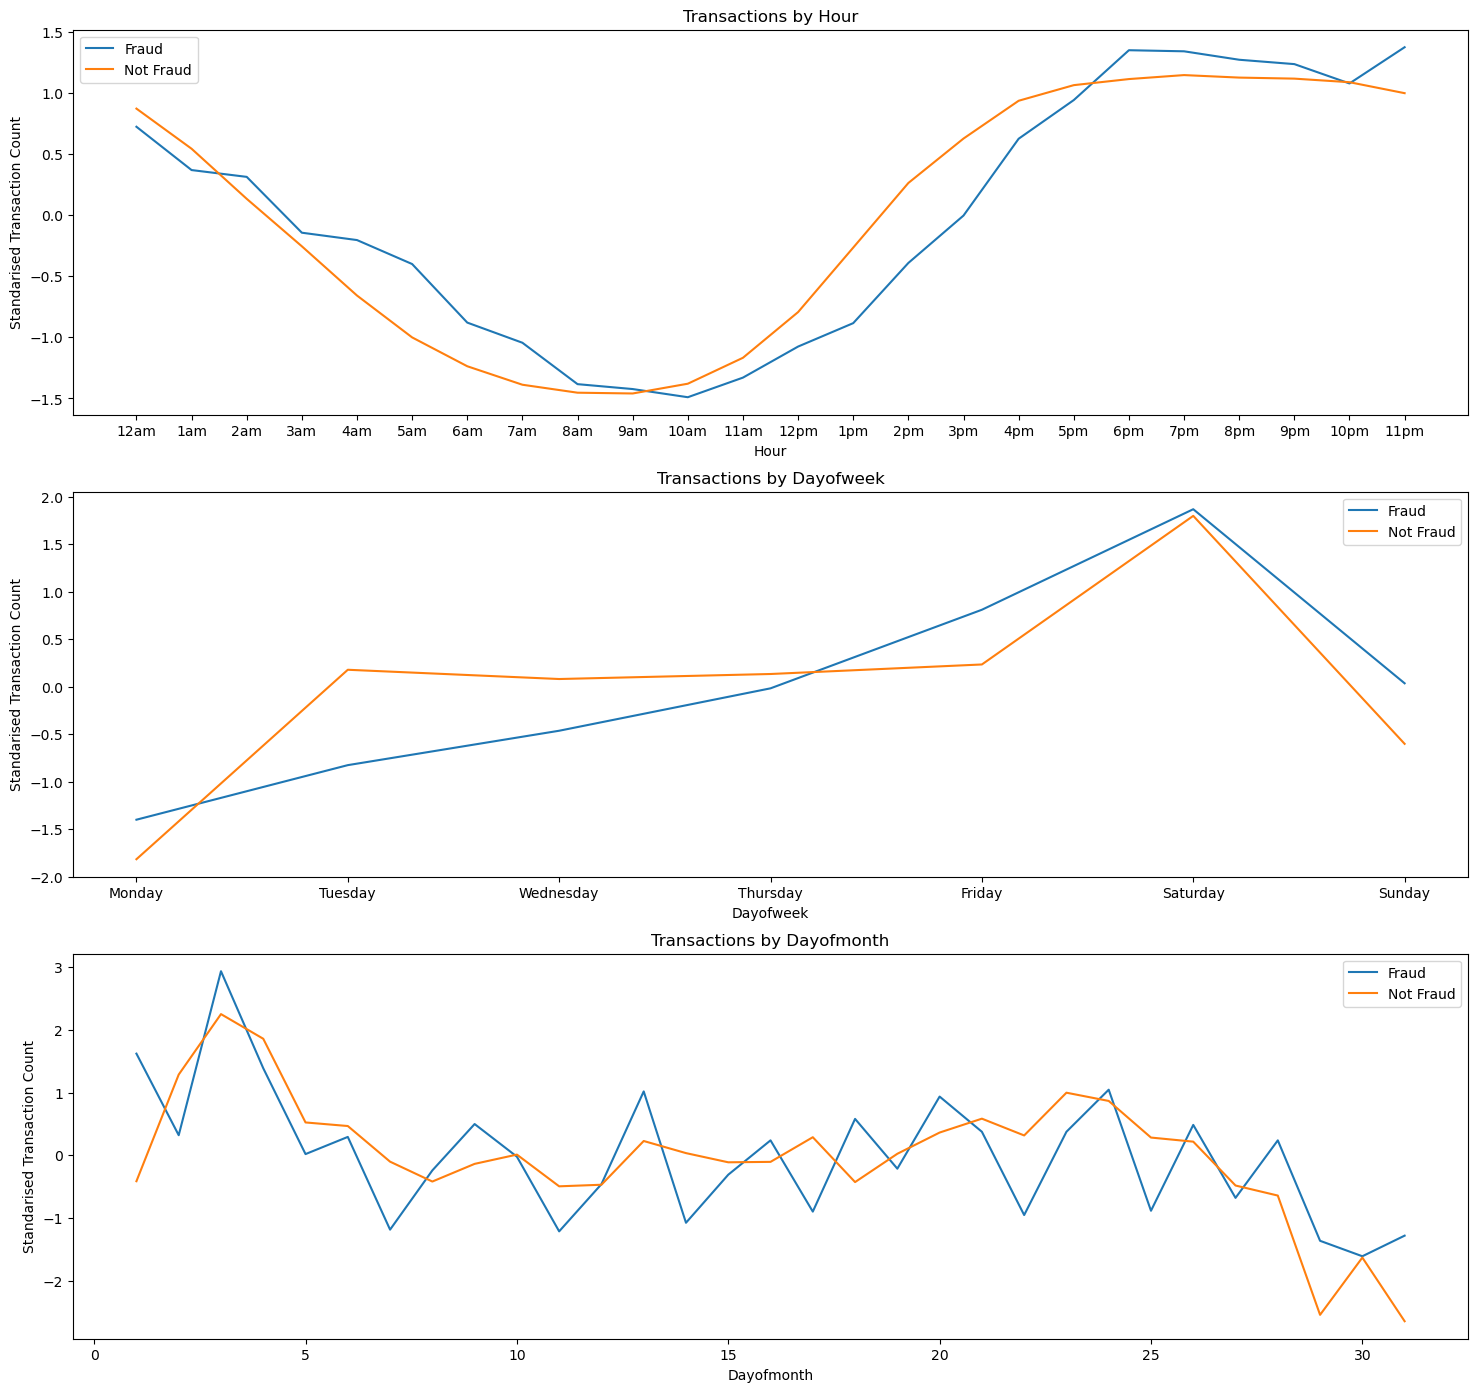

In [107]:

# Create hourly, monthly and daily aggregates. 


aggregation_periods = ["hour", "dayOfWeek", "dayOfMonth"]


# Initialise the subplot 
figure, axis = plt.subplots(3, 1, figsize=(18,17))

for i in range(0,3):
    aggregation_period = aggregation_periods[i]
    agg_trx = trx_data.groupby([aggregation_period, "isFraud"]).agg({"transactionID": ["count"], "transactionAmt": ["sum"]}).reset_index()
    agg_trx.columns = [aggregation_period , "isFraud", "transactionCount", "transactionAmount"]

    agg_trx_fraud_x = agg_trx[agg_trx["isFraud"]==1][aggregation_period].tolist()
    agg_trx_not_fraud_x = agg_trx[agg_trx["isFraud"]==0][aggregation_period].tolist()
    # Standardise counts so we can view both fraudulent and non-fraudulent on one chart
    agg_trx_fraud_y = standardise(agg_trx[agg_trx["isFraud"]==1]["transactionCount"].tolist())
    agg_trx_not_fraud_y = standardise(agg_trx[agg_trx["isFraud"]==0]["transactionCount"].tolist())


    

  
    axis[i].plot(agg_trx_fraud_x , agg_trx_fraud_y, label="Fraud", )
    axis[i].plot(agg_trx_not_fraud_x , agg_trx_not_fraud_y, label="Not Fraud" )
    axis[i].legend()


    axis[i].set_title("Transactions by "+aggregation_period.capitalize())

    if aggregation_period != "dayOfMonth":
        agg_trx_not_fraud_x_labels = [calendar_label_dict[aggregation_period][x] for x in agg_trx_not_fraud_x]
        axis[i].set_xticks(agg_trx_not_fraud_x, labels=agg_trx_not_fraud_x_labels)
    axis[i].set_ylabel('Standarised Transaction Count')
    axis[i].set_xlabel(aggregation_period.capitalize())

plt.show()



In the above plots we can see fraudulent activity peak at 6pm, an hour after non-fraudulent transaction peak. It appears that fraudulent transactions lag non-fraudulent transactions by about an hour.  This may be because a non-fraudulent transaction is conducted and it is this transactions which leads to credit card details being compromised. Shortly after the the credit card is used for fraudulent transaction. 

Unlike the day the time of the day, there doesn't appear as strong a correlation between fraudulent and non-fraudulent transactions when we look at the day of the week. The non-fraudulent transaction begining to increase on Friday, peaking on Saturday. This would be the period when people go out and spend money. Given the hypothesis above it makes sense that fraudulent transactions also peak on Saturday, given that is when credit card spending is most frequent. There may also be less fraudulent transactions during the week as people are more likely to spend on their credit cards where there are less chances of credit card details being compromised, for example at the super market or local cafe

### Create moving averages and identify seasonal trends (also includes window like functions)



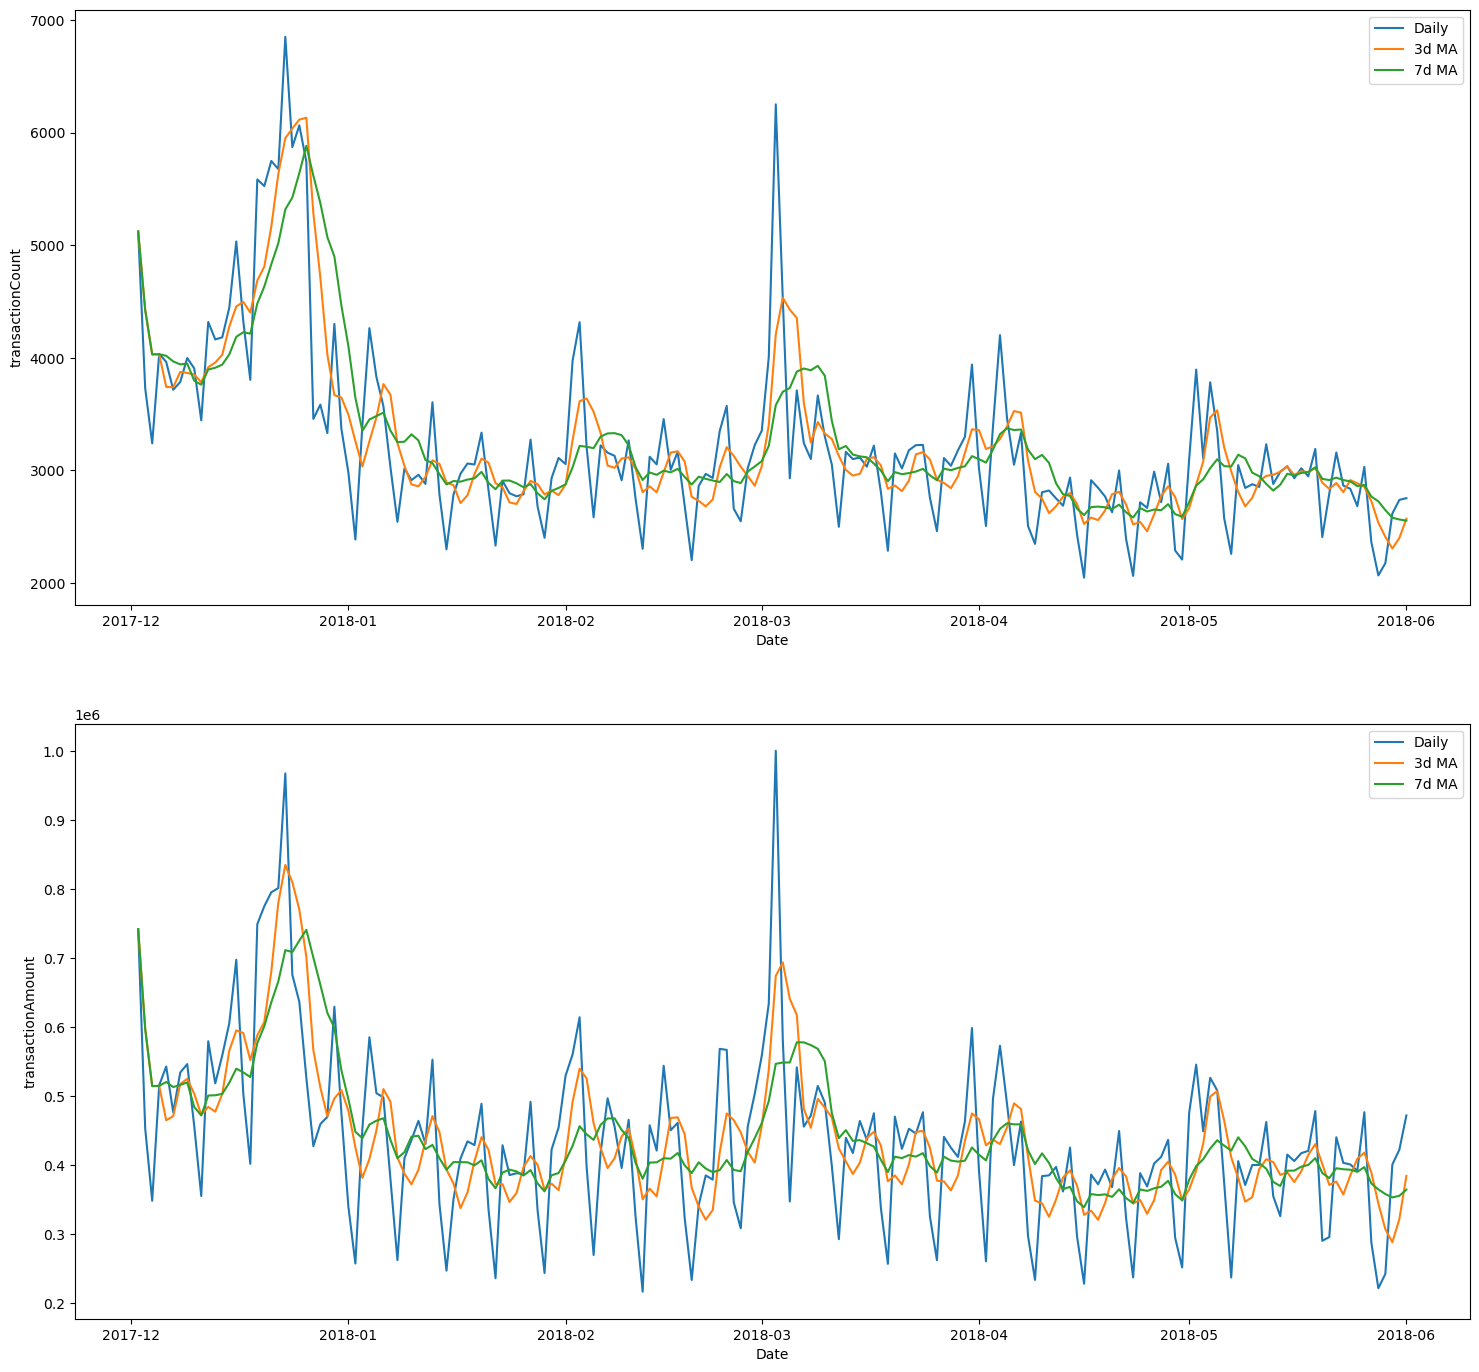

In [130]:
# Aggregate over transaction date
daily_trx = trx_data.groupby(["date"]).agg({"transactionID": ["count"], "transactionAmt": ["sum"]}).reset_index()
daily_trx .columns = ["date", "transactionCount", "transactionAmount"]


daily_trx = daily_trx.sort_values(by="date")
figure, axis = plt.subplots(2, 1, figsize=(18,17))

for i in range(0,2):  
    column_to_aggregate = ["transactionCount", "transactionAmount"][i]
    daily_trx ["3dMA"] = daily_trx ["date"].apply(lambda x: rolling_average(3,x, daily_trx, column_to_aggregate ))
    daily_trx ["7dMA"] = daily_trx ["date"].apply(lambda x: rolling_average(7, x, daily_trx, column_to_aggregate ))
    
    axis[i].plot(daily_trx ["date"], daily_trx [column_to_aggregate], label="Daily")
    axis[i].plot(daily_trx  ["date"], daily_trx ["3dMA"], label="3d MA")
    axis[i].plot(daily_trx  ["date"], daily_trx ["7dMA"], label="7d MA")
    axis[i].set_xlabel("Date")
    axis[i].set_ylabel(column_to_aggregate)
    axis[i].legend()
plt.show()


In the above chart we see the number of transaction is higher in December, which is the Christmas period. We can also observe the weekly patterns, as transactions rise and fall. 

### Develop statistical measures for anomaly detection

Below are some examples of detecting anomolies: 

1. An outlier in the typical transactions amount (with and without controls). 
2. Deviation by transaction frequency by hour. 
4. Spending beyond what the uid normally spends 


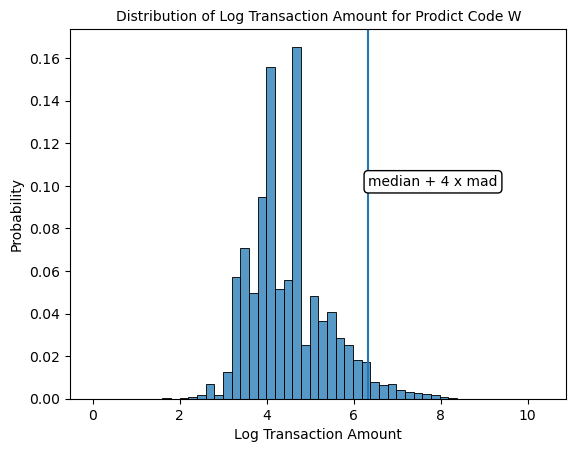

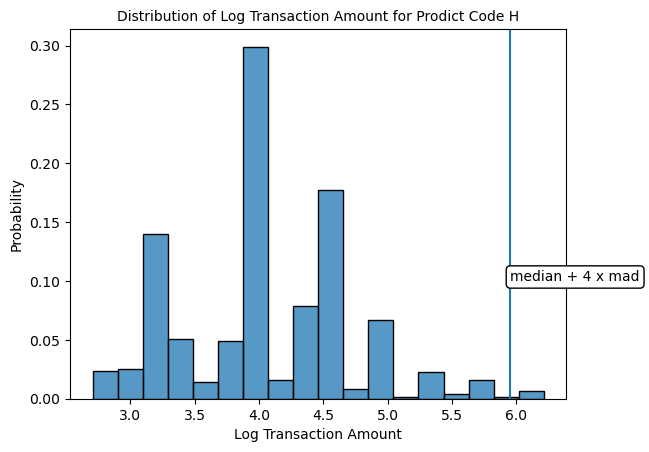

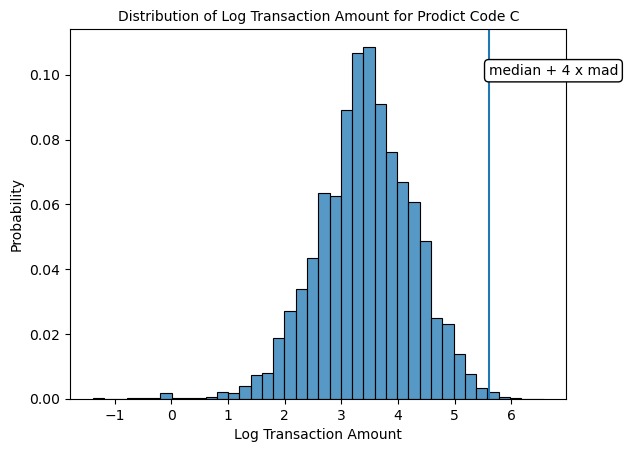

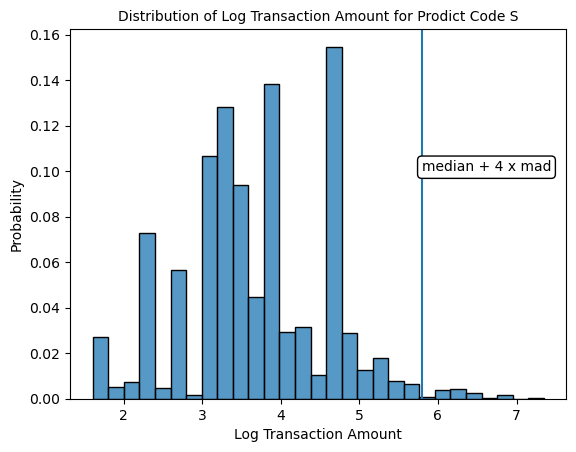

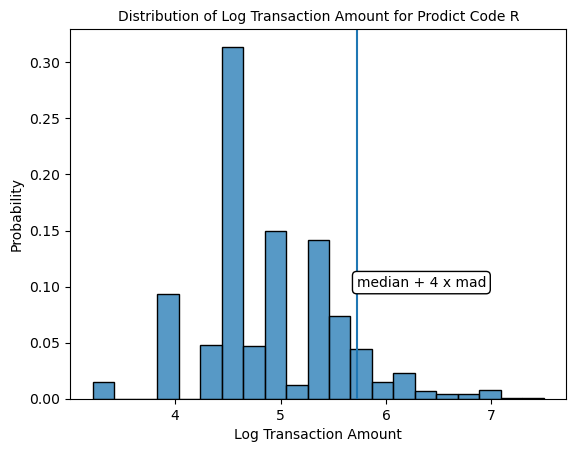

In [123]:
# Below we display transaction amounts that are outliers according to the rule that the log transaction value is 34 median absolute deviatons (MAD)
# away from the median. I use the median and MAD instead of mean and standard deviation as the data is skewed, even after taking logarithmic transformation. 


# We will create a histogram for each product code as what is normal for each product code can vary. 
unique_cd = trx_data["productCD"].unique()
n_unique_cd = len(unique_cd )


for i in range(n_unique_cd):
    data = trx_data[trx_data["productCD"]==unique_cd[i]]
    axis = sns.histplot(data, x="logTransactionAmt",stat="probability",  binwidth=.2)
    # ticks 
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Calculate median and median absolute deviation. This is out statistical measure of anomoly detection. 
    median = np.median(data["logTransactionAmt"])
    mad = scipy.stats.median_abs_deviation(data["logTransactionAmt"])
    outlier = median+4*mad

    
    plt.axvline(outlier, 0,1)
    axis.annotate('median + 4 x mad', xy=( outlier, .1), xytext=(outlier, .1), fontsize=10, bbox=dict(boxstyle="round", fc="1"))

    # labels and title
    plt.xlabel('Log Transaction Amount', fontsize=10)
    plt.ylabel('Probability', fontsize=10)
    plt.title('Distribution of Log Transaction Amount for Prodict Code '+unique_cd[i], fontsize=10);
    plt.show()
 


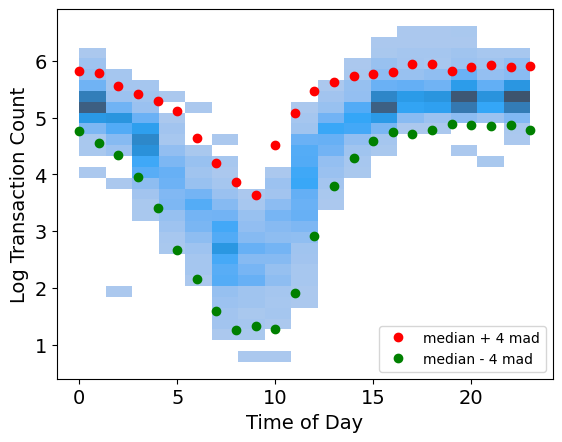

In [126]:
# We can also see whether there are any days where the number of transactions at a particular point in the day were above normal. Once
# again we define above normal as those that are 4 median absolute deviations away from the median. 

# First we will calculate the number of transactions that occur for each hour on a given day, this will be our sample

day_hour_trx = trx_data.groupby(["date", "hour"]).agg({"transactionID": ["count"]}).reset_index()
day_hour_trx  .columns = ["date", "hour", "transactionCount"]
day_hour_trx["logTransactionCount"] = np.log(day_hour_trx["transactionCount"])

sns.histplot(day_hour_trx, x='hour', y="logTransactionCount")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Log Transaction Count', fontsize=14)

# Given the data is skewed we will once again utilise the median and median absolute deviaion. 
hour_summary = day_hour_trx.groupby("hour").agg({"logTransactionCount": ["median", scipy.stats.median_abs_deviation]}).reset_index()
hour_summary.columns =  ["hour", "median" ,"mad"]
y_max = hour_summary["median"] + 4*hour_summary["mad"]
y_min = hour_summary["median"] - 4*hour_summary["mad"]

x = hour_summary["hour"]
plt.plot(x,y_max , "or", label="median + 4 mad")
plt.plot(x,y_min , "og", label="median - 4 mad")

plt.legend(loc="lower right")

In the above chart, the transaction counts above the red dots are outliers. They are significantly higher (3 median absolute deviations) away from the typical transaction count for that time of the day. Similar to the transaction counts that are below the green lines. These transactions are unusually low. 

All the above approaches don't control for sufficient variables. For example there are many reasons why transaction amounts/counts may be above normal. To account for this I will try and control for many variables through ordinary least squares regressions and study the residuls for outliers. 

In [64]:
# If a variable is missing at least 1/3 of its rows we will exclude, otherwise we will end up dropping too many rows from the data. 
prop_null = trx_data.isnull().sum().to_frame()/len(trx_data)
prop_null.columns = ["proportionOfRowsNull"]
prop_null[prop_null["proportionOfRowsNull"]>1/3]

,proportionOfRowsNull
dist1,0.596524
dist2,0.936284
rEmaildomain,0.767516
m1,0.459071
m2,0.459071
m3,0.459071
m4,0.476588
m5,0.593494
m7,0.586353
m8,0.586331


In [66]:
categorical_variables = ["productCD",  "card2", "card3", "card4","card5", "card6", "addr1", "addr2", "hour", "dayOfMonth" ]
# Add categoritcal variable indicator (this tells statsmodel that it is a categorical variable)
categorical_variables = ["C("+x+")" for x in categorical_variables ]
continuous_variables = []
variables = categorical_variables + continuous_variables 
model =  "logTransactionAmt ~ " + " + ".join(variables)
model


'logTransactionAmt ~ C(productCD) + C(card2) + C(card3) + C(card4) + C(card5) + C(card6) + C(addr1) + C(addr2) + C(hour) + C(dayOfMonth)'

In [38]:
model = smf.ols(formula=model, data=trx_data).fit()

In [44]:
fitted_log_transaction_amount = model.fittedvalues
residuals = trx_data["logTransactionAmt"]-fitted_log_transaction_amount

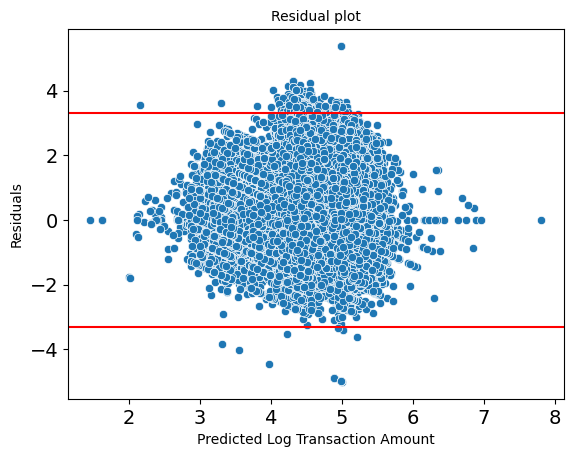

In [61]:

# scatter plot with seaborn library
sns.scatterplot(x= fitted_log_transaction_amount, y=residuals)

# ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

upper_thresh = np.mean(residuals)+4*np.std(residuals)
lower_thresh = np.mean(residuals)-4*np.std(residuals)


plt.axhline(upper_thresh, 0,10, color="r")
plt.axhline(lower_thresh, 0, 10, color="r")

# labels and title
plt.xlabel('Predicted Log Transaction Amount', fontsize=10)
plt.ylabel('Residuals', fontsize=10)
plt.title('Residual plot', fontsize=10);

The residuals that are above the upper and lower band can be deemed to be outliers (so long as the model is correctly specified, and the conditions of OLS are met)